In this article, I'll share my experience with Xarray's stack method when working with large datasets and how I discovered a more efficient way of stacking per chunk (blockwise) to improve performance. Please note that this article is intended for readers who are already familiar with Dask and Xarray.

Chunk management is a critical aspect of optimizing performance when dealing with large datasets. However, when using Xarray's standard stack method, I encountered a significant problem. The method resulted in a high number of interdependencies between the resulting Dask graph's chunks, ultimately negatively impacting performance. Specifically, each output chunk was dependent on all input chunks along the dimension to be stacked, leading to a slow and inefficient computation process. To address this issue, I developed a custom blockwise stack function that improved performance by avoiding these interdependencies and enabling parallel computation.

It's important to note that this is **not** a bug in Xarray. Their implementation is necessary for reproducibility with different chunking schemas. However, since I was focused on performance, I decided to develop my own solution.

To illustrate the problem and its solution, I'll:

* Create a dummy dataset.
* Stack it with Xarray's stack method.
* Stack it with my own "blockwise_stack" function.
* Try to describe what's happening under the hood during each of the above steps.

I hope that by the end of this article, readers will have a better understanding of the issues surrounding Xarray's stack method and how to improve performance when working with large datasets.

### The dummy dataset.

The following is a small dummy dataset that includes a coordinate named "chunk_idx." This coordinate specifies the chunk index for each xy value, allowing us to easily observe how the chunks are affected by stacking later on.

In [12]:
import xarray as xr
import dask.array as da
import numpy as np
from blockwise_stack import blockwise_stack


one_to_six = np.array([[1, 2, 3], [4, 5, 6]])


ds = xr.Dataset(
    {
        "data": (
            ["y", "x", "band"],
            da.random.random((4, 6, 3), chunks=(2, 2, -1)),
        )
    },
    coords={
        "chunk_idx": (
            ("y", "x"),
            np.repeat(np.repeat(one_to_six, 2, axis=0), 2, axis=1),
        )
    },
)
ds.data

<xarray.DataArray 'data' (y: 4, x: 6, band: 3)>
dask.array<random_sample, shape=(4, 6, 3), dtype=float64, chunksize=(2, 2, 3), chunktype=numpy.ndarray>
Coordinates:
    chunk_idx  (y, x) int64 1 1 2 2 3 3 1 1 2 2 3 3 4 4 5 5 6 6 4 4 5 5 6 6
Dimensions without coordinates: y, x, band

In [13]:
ds.chunk_idx

<xarray.DataArray 'chunk_idx' (y: 4, x: 6)>
array([[1, 1, 2, 2, 3, 3],
       [1, 1, 2, 2, 3, 3],
       [4, 4, 5, 5, 6, 6],
       [4, 4, 5, 5, 6, 6]])
Coordinates:
    chunk_idx  (y, x) int64 1 1 2 2 3 3 1 1 2 2 3 3 4 4 5 5 6 6 4 4 5 5 6 6
Dimensions without coordinates: y, x

In [14]:
ds.data.chunks

((2, 2), (2, 2, 2), (3,))

### Stacking the dummy dataset with Xarray's stack method.

Note that each output chunk depends on **three** input chunks, which are **all** chunks over the x dimension in the dummy dataset. Although this doesn't have a significant impact on performance in this dummy example, it can become a problem when dealing with a much larger dataset with more images of a larger size, as well as an additional date dimension, which was the case I had to handle.

In [15]:
stacked = ds.stack(pixel=("y", "x"))
stacked.data

<xarray.DataArray 'data' (band: 3, pixel: 24)>
dask.array<reshape, shape=(3, 24), dtype=float64, chunksize=(3, 6), chunktype=numpy.ndarray>
Coordinates:
    chunk_idx  (pixel) int64 1 1 2 2 3 3 1 1 2 2 3 3 4 4 5 5 6 6 4 4 5 5 6 6
  * pixel      (pixel) MultiIndex
  - y          (pixel) int64 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3
  - x          (pixel) int64 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5
Dimensions without coordinates: band

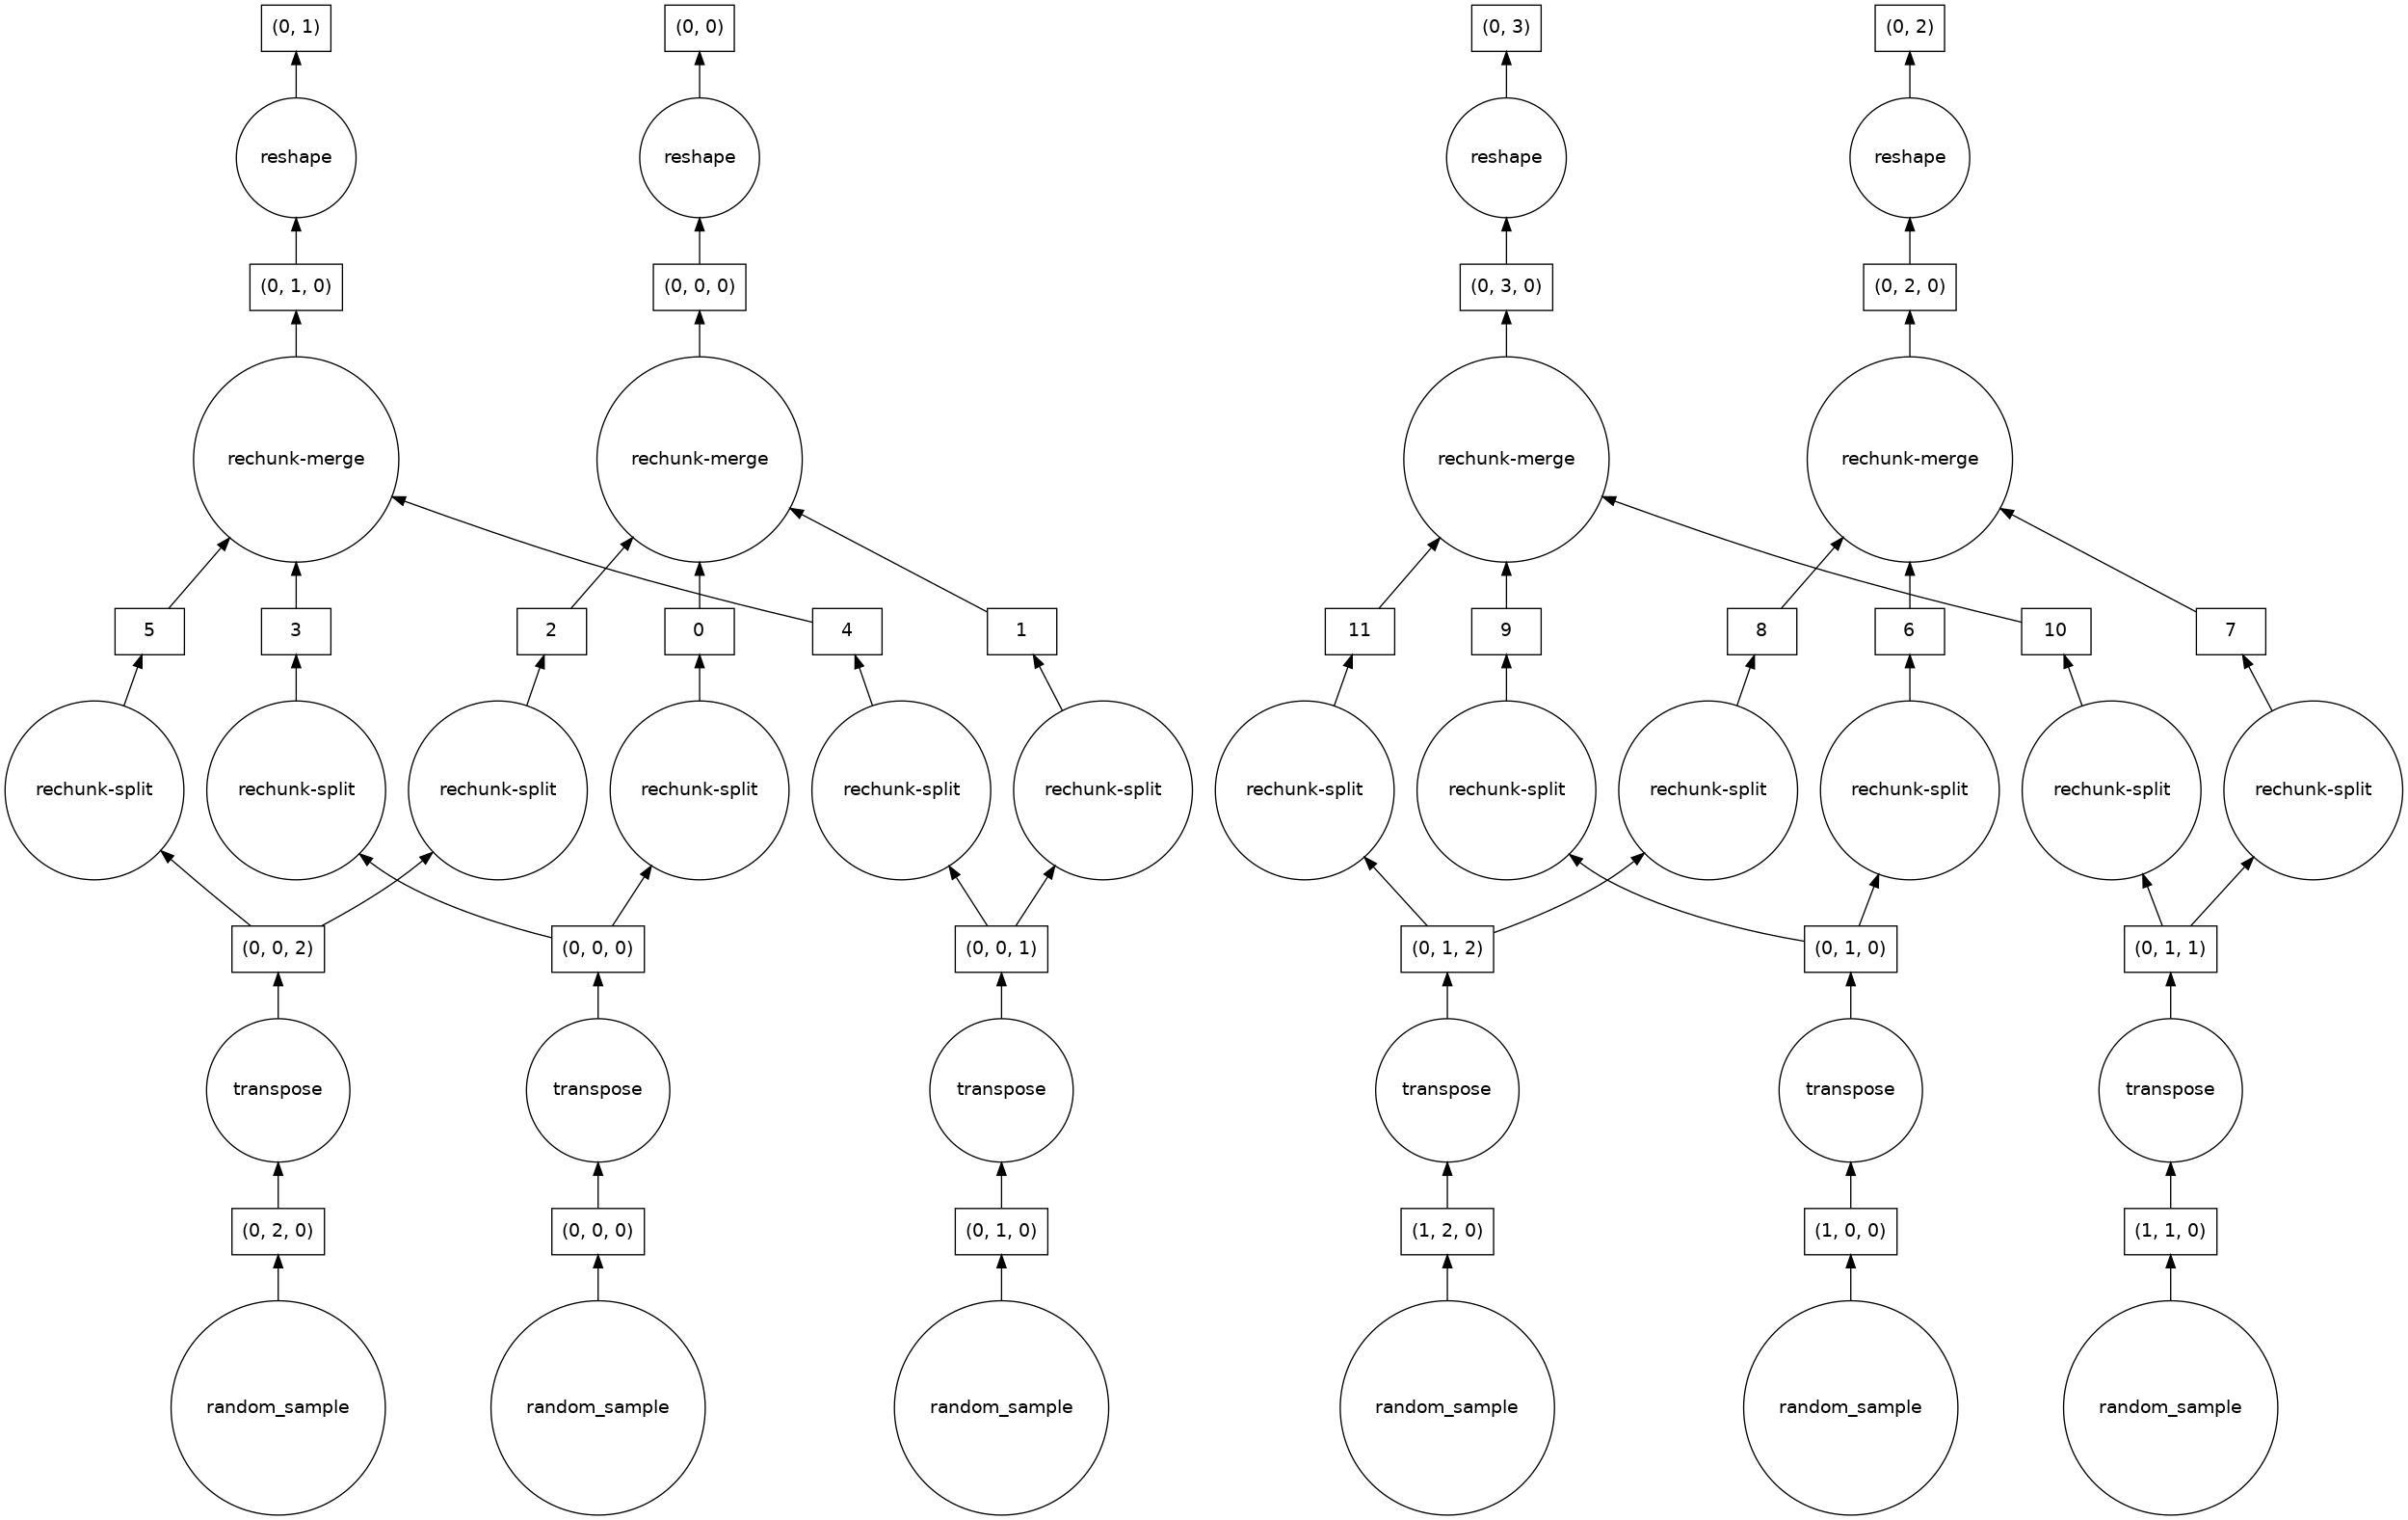

In [16]:
stacked.data.data.visualize(filename="./stacked.png")

In [17]:
stacked.chunk_idx

<xarray.DataArray 'chunk_idx' (pixel: 24)>
array([1, 1, 2, 2, 3, 3, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 4, 4, 5, 5,
       6, 6])
Coordinates:
    chunk_idx  (pixel) int64 1 1 2 2 3 3 1 1 2 2 3 3 4 4 5 5 6 6 4 4 5 5 6 6
  * pixel      (pixel) MultiIndex
  - y          (pixel) int64 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3
  - x          (pixel) int64 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5

In [18]:
stacked.data.chunks

((3,), (6, 6, 6, 6))

### Stacking the dummy dataset with my own "blockwise_stack" function.

Note that each output chunk depends on **one** input chunk. This way of stacking is much faster than Xarray's stack method because each output chunk depends on only one input chunk.

In [19]:
# blockwise_stack only works if all data variables and coordinates are Dask arrays.
# (They also have to be chunked with an identical schema, but there's no check for that.)
fully_chunked_ds = ds.copy()
fully_chunked_ds.coords["chunk_idx"] = (
    ("y", "x"),
    da.from_array(fully_chunked_ds.chunk_idx.values, chunks=(2, 2)),
)

stacked_blockwise = blockwise_stack(
    fully_chunked_ds,
    input_dims=("y", "x"),
    output_dim="pixel",
    ds_chunks={"y": 2, "x": 2, "band": -1},
)
stacked_blockwise.data

<xarray.DataArray 'data' (band: 3, pixel: 24)>
dask.array<blockwise-stack, shape=(3, 24), dtype=float64, chunksize=(3, 4), chunktype=numpy.ndarray>
Coordinates:
    chunk_idx  (pixel) int64 dask.array<chunksize=(4,), meta=np.ndarray>
Dimensions without coordinates: band, pixel

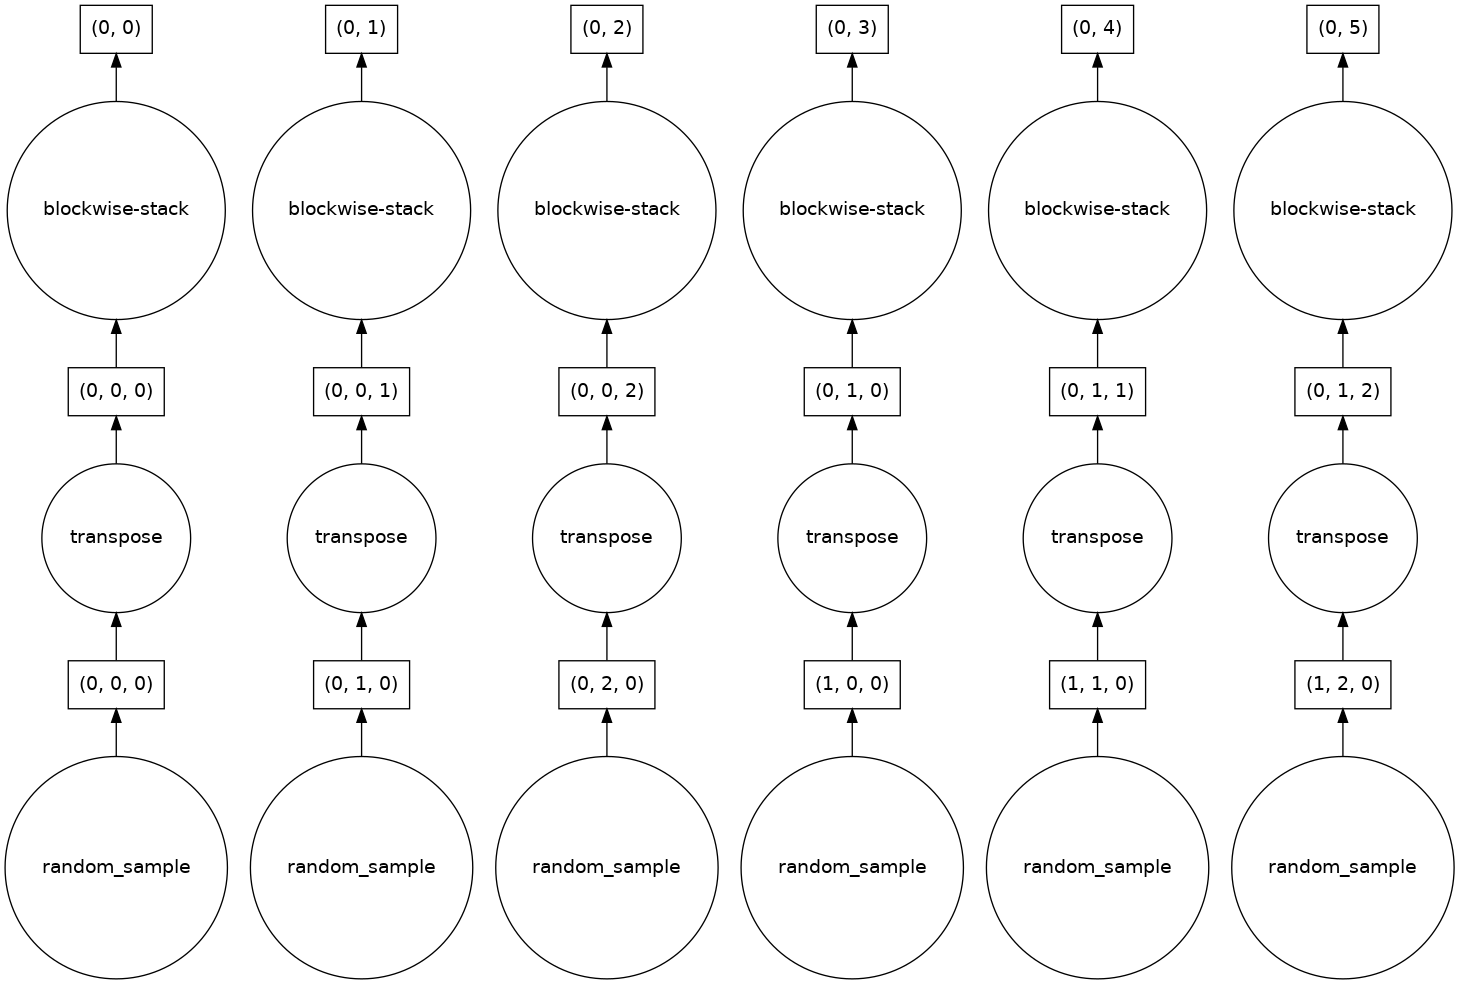

In [20]:
stacked_blockwise.data.data.visualize(filename="blockwise_stacked.png")

In [21]:
stacked_blockwise.chunk_idx.compute()

<xarray.DataArray 'chunk_idx' (pixel: 24)>
array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6,
       6, 6])
Coordinates:
    chunk_idx  (pixel) int64 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6
Dimensions without coordinates: pixel

In [22]:
stacked_blockwise.data.chunks

((3,), (4, 4, 4, 4, 4, 4))

That's it! Take a look on the [repo](https://github.com/marcus302/chunking) for the implementation of blockwise_stack.